# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [3]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

## Exploring Data 

In [9]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

In [10]:
#findout correlation between independant features and target variable
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [11]:
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

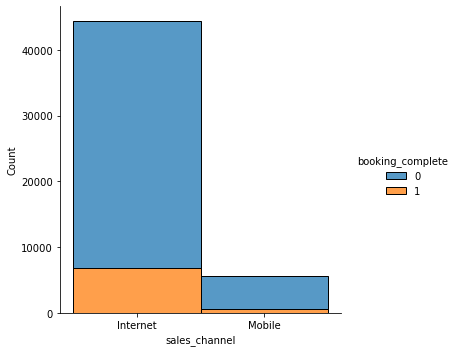

In [12]:
sns.displot(df, x="sales_channel", hue="booking_complete", multiple="stack")

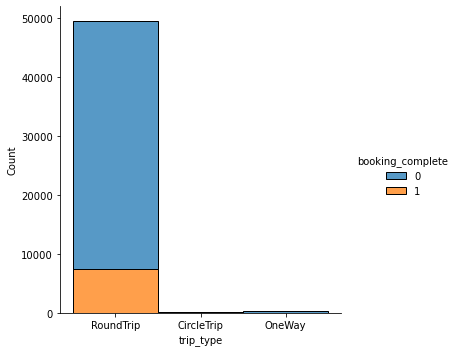

In [15]:
#for tripe type show the most booking tripe type
sns.displot(df,x ='trip_type',hue = 'booking_complete',multiple = 'stack')

In [16]:
corr_matrix = df.corr()
corr_matrix['booking_complete']

num_passengers           0.024116
purchase_lead           -0.022131
length_of_stay          -0.042408
flight_hour              0.007127
flight_day              -0.006986
wants_extra_baggage      0.068139
wants_preferred_seat     0.050116
wants_in_flight_meals    0.026511
flight_duration         -0.106266
booking_complete         1.000000
Name: booking_complete, dtype: float64

you can see there are no correlation between features and target variable ,but hwo about correlation between features it's self

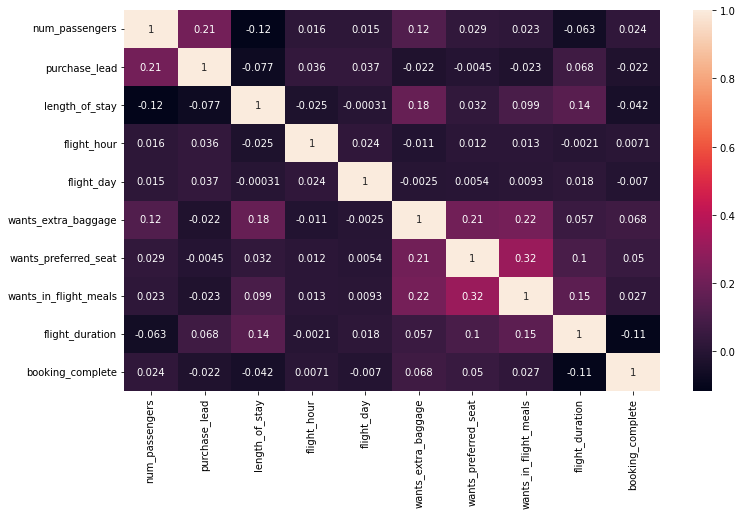

In [17]:
#find distibution for categorical data 
# Plot heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(corr_matrix, annot=True)
# Show plot
plt.show()

 you can see the correlation between all these features are very low so we will use all of them to predict booking_compelete target variable
 -

In [14]:
#we now make some vectorization for target variable using oneHotencoder from sklean
# Use LabelEncoder and OneHotEncoder to transform categorical columns into numerical indices and one-hot encoded arrays
le = LabelEncoder()
dummies_df = pd.get_dummies(df)
df_le = df.apply(le.fit_transform) # Apply LabelEncoder to each column

In [19]:
dummies_df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,2,262,19,7,6,1,0,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
1,1,112,20,3,6,0,0,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
2,2,243,22,17,3,1,1,0,5.52,0,...,0,0,0,0,0,0,0,0,0,0
3,1,96,31,4,6,0,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0
4,2,68,22,15,3,1,0,1,5.52,0,...,0,0,0,0,0,0,0,0,0,0


We will iterate  tow mechanismes of get_dummies function and LabelEncoder to choose whose best for ML Model

In [20]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [15]:
#lets know what is the shape for both get_dummies adn LabelEncoder
print('Shape for Result of get_dummies',dummies_df.shape)
print('Shape for Result of LablEncoder',df_le.shape)
print('Shape for original Data',df.shape)

Shape for Result of get_dummies (50000, 918)
Shape for Result of LablEncoder (50000, 14)
Shape for original Data (50000, 14)


## Prepare the data models 

#### first we will use Label encoder which contain less features and see influence that in models performance
we also seperate target variable form independant variable

In [17]:
X = df_le.drop(['booking_complete'],axis=1)
Y = df_le['booking_complete']
trainX, testX, trainY, testY =train_test_split(X,Y,test_size=0.4,random_state=42)
valX, testX, valY, testY = train_test_split(testX, testY, test_size=0.5, random_state=42)

In [23]:
#find out each size for splitting valus for train and test
names = ['trainX', 'testX', 'trainY', 'testY','valY']
for i,col in enumerate([trainX, testX, trainY, testY,valY]):
    print('the lenght for {} is {} '.format(names[i], round(len(col)/len(df_le),3)))

the lenght for trainX is 0.6 
the lenght for testX is 0.2 
the lenght for trainY is 0.6 
the lenght for testY is 0.2 
the lenght for valY is 0.2 


In [24]:
#Now let's standard our data
# Scale X data, we scale the data because it helps the algorithm to converge
# and helps the algorithm to not be greedy with large values
std = StandardScaler()
std.fit(trainX)
std_trans_train = std.transform(trainX)
std_trans_test = std.transform(testX)

### we now save prepared data form model development

In [19]:
names = ['trainX', 'testX', 'trainY', 'testY','valY']
for i in [trainX, testX, trainY, testY,valY]:
    print(i.shape)

(30000, 13)
(10000, 13)
(30000,)
(10000,)
(10000,)


In [26]:
trainX.to_csv('../Data/train_features.csv', index=False)
testX.to_csv('../Data/test_features.csv', index=False)
trainY.to_csv('../Data/train_labels.csv', index=False)
testY.to_csv('../Data/test_labels.csv', index=False)
valX.to_csv('../Data/val_features.csv', index=False)
valY.to_csv('../Data/val_labels.csv', index=False)

#also we save scaller data to optional chooices for Model perforamce
std_trans_train = pd.DataFrame(std_trans_train)
std_trans_test = pd.DataFrame(std_trans_test)
std_trans_train.to_csv('../Data/train_scale_features.csv',index = False)
std_trans_test.to_csv('../Data/train_scale_labels.csv',index = False)